In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pickle
import seaborn as sns

import torch as th
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import roc_curve, roc_auc_score, auc

th.manual_seed(42)

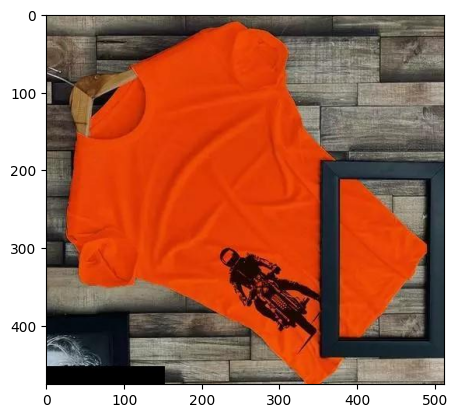

(476, 512, 3)

In [2]:
sample = plt.imread('train_images/000000.jpg')
plt.imshow(sample)
plt.show()

sample.shape

In [3]:
# scale the resolution of all the images 128x128, while keeping the aspect ratio, and padding the rest
def scale_and_pad(img, size):
    h, w = img.shape[:2]
    scale = size / float(max(h, w))
    new_w, new_h = int(w * scale), int(h * scale)
    resized_image = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    # Create a new image of the desired size, filled with the padding color
    pad_w = (size - new_w) // 2
    pad_h = (size - new_h) // 2
    padded_image = cv2.copyMakeBorder(resized_image, pad_h, size - new_h - pad_h, pad_w, size - new_w - pad_w, cv2.BORDER_CONSTANT, value=0)
    return padded_image

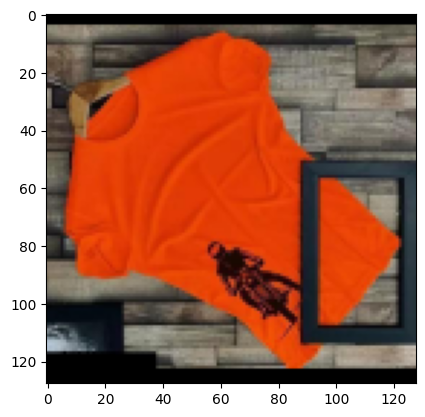

(128, 128, 3)

In [4]:
sample_scaled = scale_and_pad(sample, 128)
plt.imshow(sample_scaled)
plt.show()

sample_scaled.shape

In [5]:
class ImageDataset(Dataset):
    def __init__(self, images_path, y, size=128):
        self.y = y
        self.images_path = images_path
        self.size = size
        self.image_files = sorted(os.listdir(images_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load and preprocess image on demand
        path = os.path.join(self.images_path, self.image_files[idx])
        # print(path)
        img = plt.imread(path)
        img = scale_and_pad(img, self.size)
        img = th.tensor(img).permute(2, 0, 1).float() / 255.0
        return img, self.y[idx]

In [6]:
lbe = LabelEncoder()

train_images_path = 'train_images'
train_pd = pd.read_csv('train.csv')
train_y = train_pd['Category'].values
train_y = lbe.fit_transform(train_y)

lbe.classes_

array(['Kurtis', 'Men Tshirts', 'Sarees', 'Women Tops & Tunics',
       'Women Tshirts'], dtype=object)

In [7]:
for i in sorted(os.listdir('train_images')):
    id = int(i.split('.')[0])
    if id not in train_pd['id'].values:
        print(id)
        os.remove(os.path.join('train_images', i))

In [8]:
train_dataset = ImageDataset(train_images_path, train_y)

with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

In [9]:
test_images_path = 'test_images'
test_pd = pd.read_csv('test.csv')
test_y = test_pd['Category'].values
test_y = lbe.transform(test_y)

In [10]:
for i in sorted(os.listdir('test_images')):
    id = int(i.split('.')[0])
    if id not in test_pd['id'].values:
        print(id)
        os.remove(os.path.join('test_images', i))

In [11]:
test_dataset = ImageDataset(test_images_path, test_y)

with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)

In [12]:
images = os.listdir('train_images')
print(len(images))

70213


torch.Size([3, 128, 128]) 3


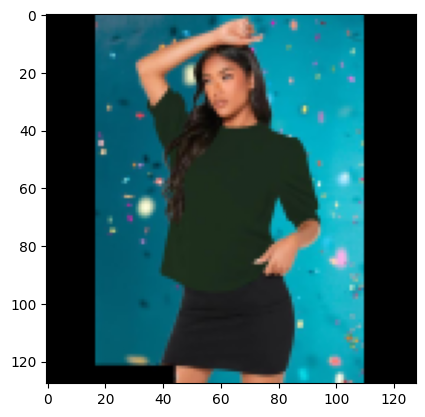

In [13]:
sample, label = train_dataset[len(train_dataset) - 2]
print(sample.shape, label)

sample = sample.numpy().transpose(1, 2, 0)
plt.imshow(sample)
plt.show()

torch.Size([3, 128, 128]) 3


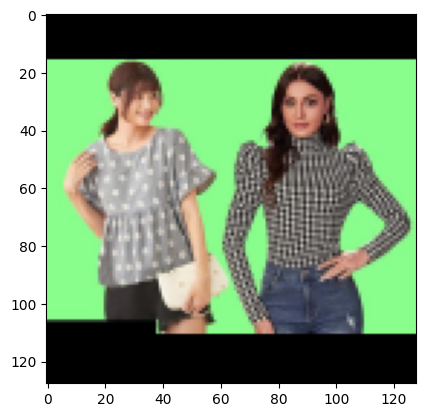

In [14]:
test_sample, test_label = test_dataset[len(test_dataset) - 2]
print(test_sample.shape, test_label)

test_sample = test_sample.numpy().transpose(1, 2, 0)
plt.imshow(test_sample)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

In [16]:
class CategoryClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(CategoryClassifier, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2),     # 32x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 32x32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),    # 64x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 64x8x8

            nn.Flatten(),

            nn.Linear(64*8*8, 512),                                 # 512
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 64),                                     # 64   
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, num_classes)                             # 5
        )

    def forward(self, x):
        return self.model(x)

model = CategoryClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=0.001)

device = th.device('mps')
model.to(device)

CategoryClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4096, out_features=512, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=512, out_features=64, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [17]:
def train_model(model : CategoryClassifier, criterion : nn.Module, optimizer : th.optim.Optimizer, train_loader : DataLoader, test_loader : DataLoader, num_epochs=10):
    loss_hist = []
    epoch_hist = []
    test_loss_hist = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if i % 100 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}, Iteration {i + 1}/{len(train_loader)}, Loss: {loss.item()}')
                loss_hist.append(loss.item())

        epoch_hist.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0.0
        with th.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()

        test_loss_hist.append(test_loss / len(test_loader))

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader)}, Test Loss: {test_loss / len(test_loader)}')
        
    return loss_hist, epoch_hist, test_loss_hist

In [18]:
train_loss, epoch_loss, test_loss = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10)

Epoch 1/10, Iteration 1/549, Loss: 1.6081867218017578
Epoch 1/10, Iteration 101/549, Loss: 0.7490624785423279
Epoch 1/10, Iteration 201/549, Loss: 0.4286024570465088
Epoch 1/10, Iteration 301/549, Loss: 0.45306211709976196
Epoch 1/10, Iteration 401/549, Loss: 0.4638630151748657
Epoch 1/10, Iteration 501/549, Loss: 0.4216013550758362
Epoch 1/10, Train Loss: 0.619288113924975, Test Loss: 0.5299727068109027
Epoch 2/10, Iteration 1/549, Loss: 0.47058671712875366
Epoch 2/10, Iteration 101/549, Loss: 0.31247276067733765
Epoch 2/10, Iteration 201/549, Loss: 0.3309667110443115
Epoch 2/10, Iteration 301/549, Loss: 0.33801841735839844
Epoch 2/10, Iteration 401/549, Loss: 0.30872154235839844
Epoch 2/10, Iteration 501/549, Loss: 0.2221577912569046
Epoch 2/10, Train Loss: 0.32155758096329284, Test Loss: 0.38299946295949866
Epoch 3/10, Iteration 1/549, Loss: 0.2871992290019989
Epoch 3/10, Iteration 101/549, Loss: 0.31048911809921265
Epoch 3/10, Iteration 201/549, Loss: 0.21060305833816528
Epoch 3/10

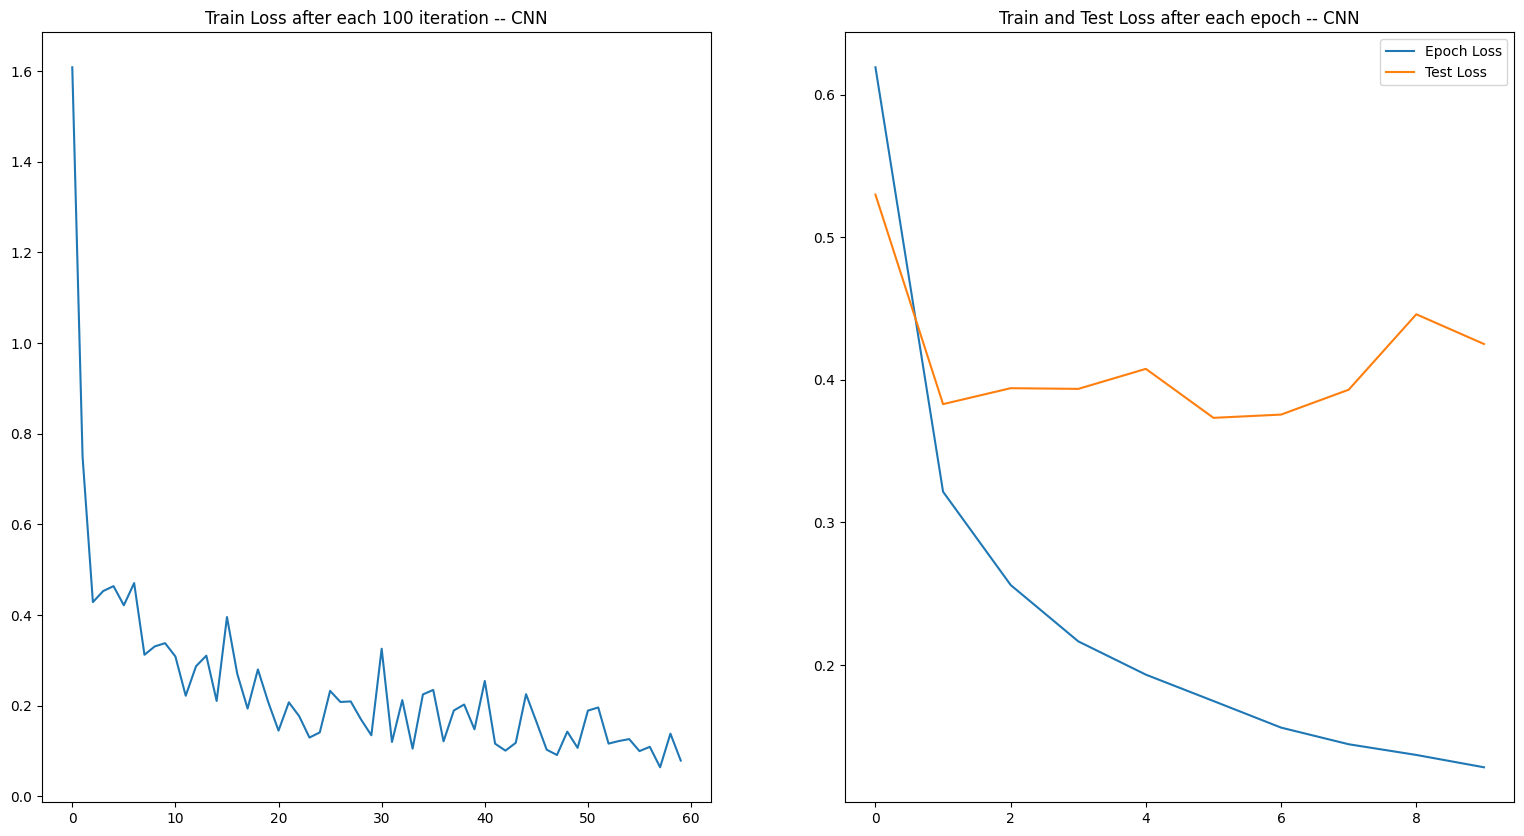

In [38]:
plt.figure(figsize=(19, 10))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.title('Train Loss after each 100 iteration -- CNN')

plt.subplot(1, 2, 2)
plt.plot(epoch_loss, label='Epoch Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Train and Test Loss after each epoch -- CNN')
plt.legend()
plt.show()

In [20]:
# Save the model
th.save(model.state_dict(), 'model.pth')
# del model

In [29]:
model = CategoryClassifier()
model.load_state_dict(th.load('model.pth'))
model.to(device)

/var/folders/tc/8g6g_hgn5zx4bzcxx9688mhw0000gn/T/ipykernel_4018/2603587377.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('model.pth'))


CategoryClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4096, out_features=512, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=512, out_features=64, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [30]:
def evaluate_model_predictions(model : CategoryClassifier, test_loader : DataLoader):
    y_pred = []
    y_true = []
    model.eval()
    with th.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = th.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_true, y_pred


0.8822380400595928
                     precision    recall  f1-score   support

             Kurtis       0.90      0.91      0.90      2460
        Men Tshirts       0.93      0.88      0.90      3787
             Sarees       0.98      0.95      0.96      7102
Women Tops & Tunics       0.78      0.84      0.81      6925
      Women Tshirts       0.87      0.86      0.86      9931

           accuracy                           0.88     30205
          macro avg       0.89      0.89      0.89     30205
       weighted avg       0.88      0.88      0.88     30205



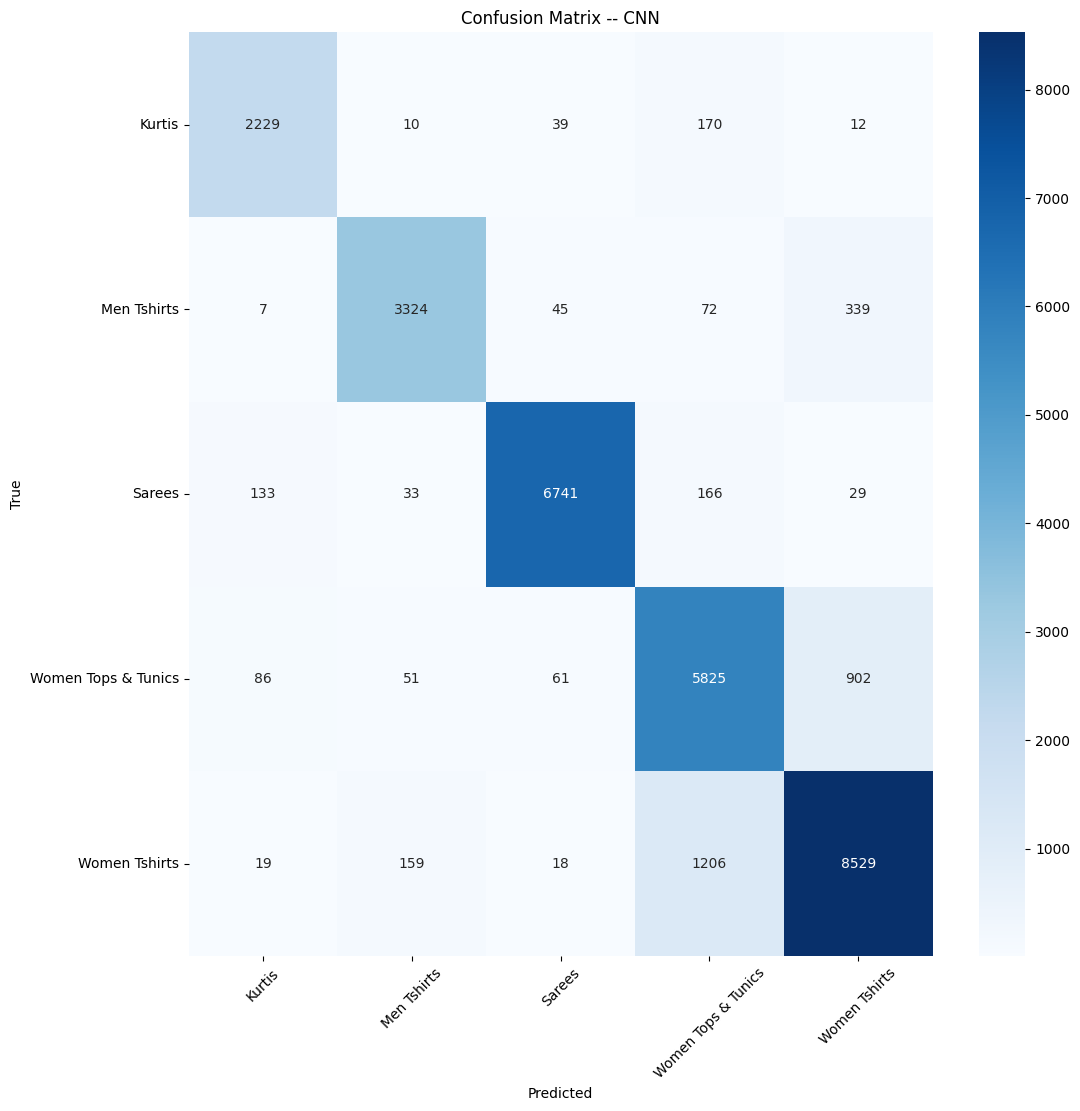

In [31]:
y_true, y_pred = evaluate_model_predictions(model, test_loader)

print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=lbe.classes_))

plt.figure(figsize=(12, 12))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=lbe.classes_, yticklabels=lbe.classes_, cmap='Blues')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix -- CNN')
plt.show()

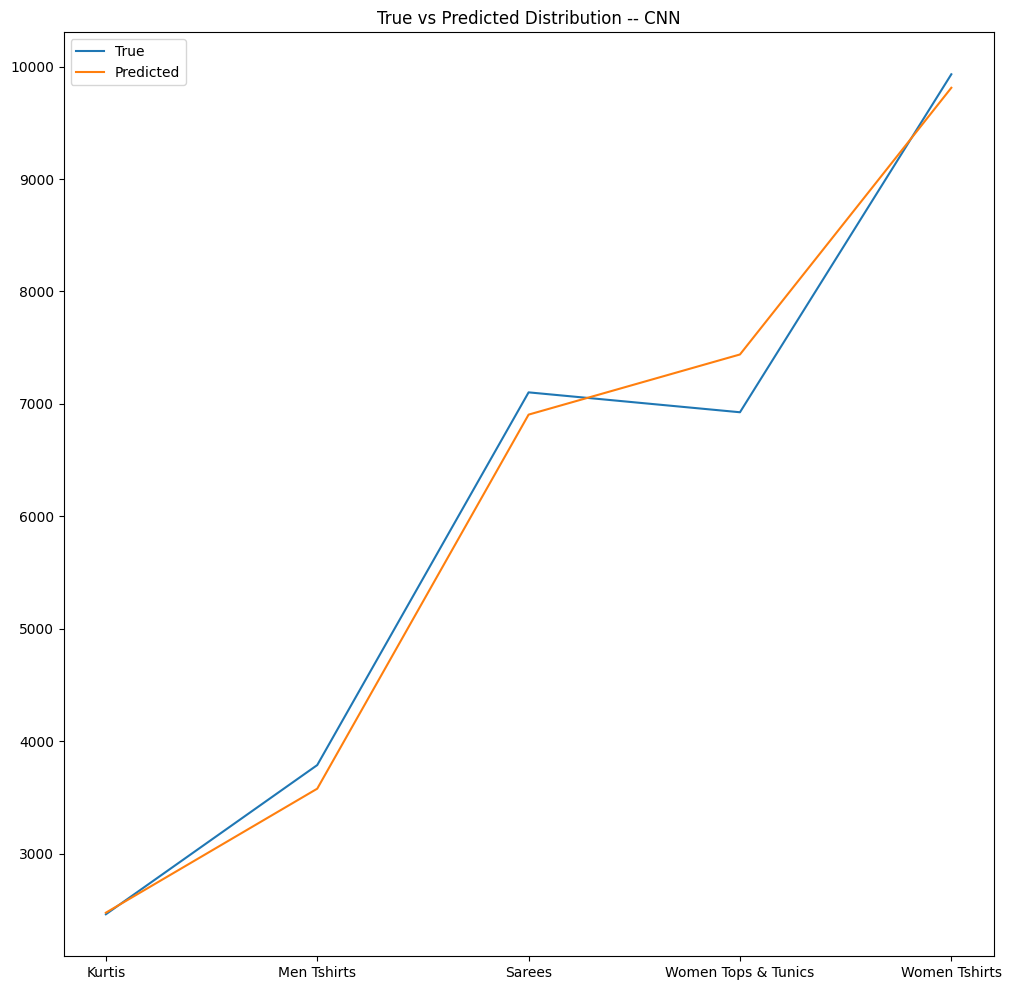

In [39]:
plt.figure(figsize=(12, 12))
plt.plot(lbe.classes_, cm.sum(axis=1), label='True')
plt.plot(lbe.classes_, cm.sum(axis=0), label='Predicted')
plt.legend()
plt.title('True vs Predicted Distribution -- CNN')
plt.show()

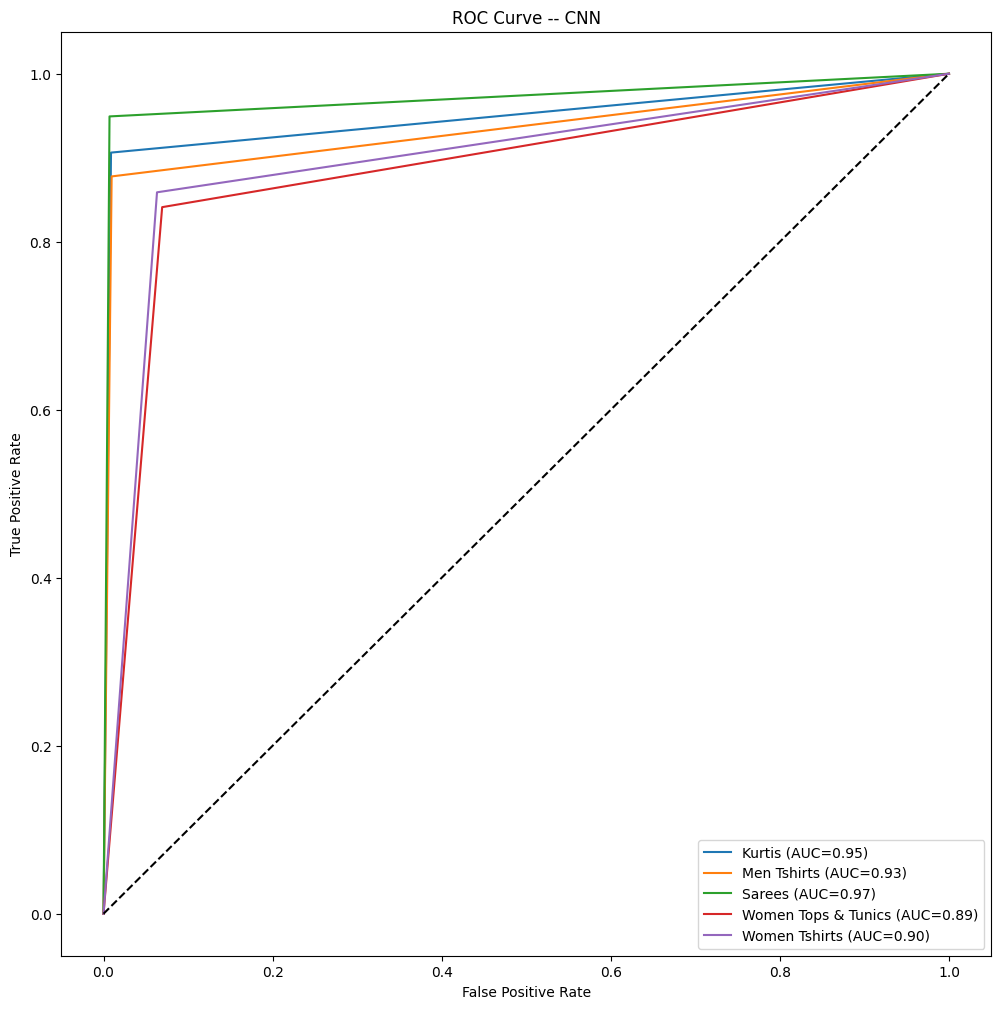

0.9263987750372455

In [40]:
# ROC Curve
y_true_onehot = np.eye(5)[y_true]
y_pred_onehot = np.eye(5)[y_pred]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 12))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'{lbe.classes_[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- CNN')
plt.legend()
plt.show()

# ROC AUC Score
roc_auc_score(y_true_onehot, y_pred_onehot, average='micro')

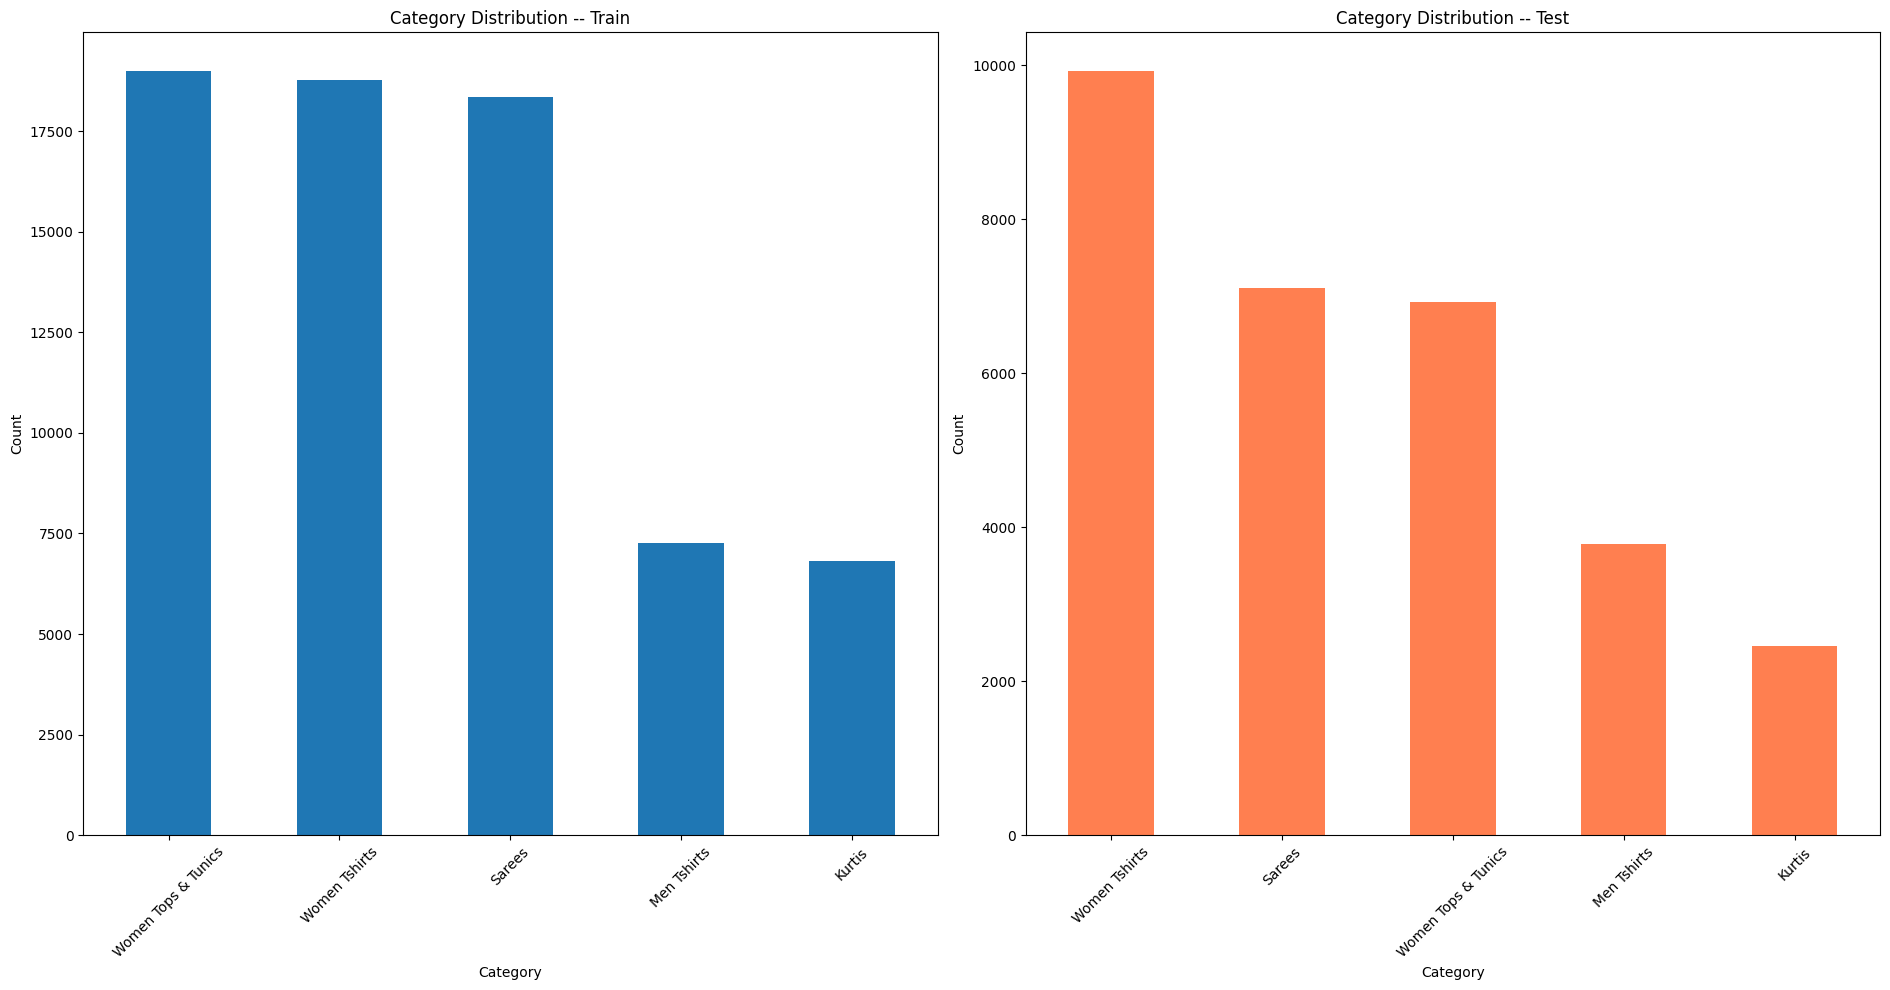

In [35]:
# count the number of images in each category and plot the distribution
plt.figure(figsize=(19, 10))
plt.subplot(1, 2, 1)
train_pd['Category'].value_counts().plot(kind='bar')
plt.title('Category Distribution -- Train')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
test_pd['Category'].value_counts().plot(kind='bar', color = 'coral')
plt.title('Category Distribution -- Test')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### UNDERSAMPLED DATA

In [87]:
train_under_path = "train_images_under"
os.makedirs(train_under_path, exist_ok=True)
test_under_path = "test_images_under"
os.makedirs(test_under_path, exist_ok=True)

In [88]:
# take 1000 images from each category and make a copy of them in a new directory
for category in lbe.classes_:
    category_images = train_pd[train_pd['Category'] == category]['id'].values[:5000]
    category_images = [str(image).zfill(6) for image in category_images]
    for image in category_images:
        os.system(f'cp train_images/{image}.jpg {train_under_path}/{image}.jpg')

    # category_images = test_pd[test_pd['Category'] == category]['id'].values[:1000]
    # for image in category_images:
    #     os.system(f'cp test_images/{image}.jpg {test_under_path}/{image}.jpg')

train_under_pd = train_pd[train_pd['id'].isin([int(i.split('.')[0]) for i in os.listdir(train_under_path)])]

In [89]:
train_under_y = lbe.transform(train_under_pd['Category'].values)
train_under_dataset = ImageDataset(train_under_path, train_under_y)

In [90]:
# take random 2500 images from test set and make a copy of them in a new directory
test_images_under = np.random.choice(test_pd['id'].values, 10000, replace=False)
test_images_under = [str(image).zfill(6) for image in test_images_under]
for image in test_images_under:
    os.system(f'cp test_images/{image}.jpg {test_under_path}/{image}.jpg')

test_under_pd = test_pd[test_pd['id'].isin([int(i.split('.')[0]) for i in os.listdir(test_under_path)])]

In [91]:
test_under_y = lbe.transform(test_under_pd['Category'].values)
test_under_dataset = ImageDataset(test_under_path, test_under_y)

In [95]:
train_under_loader = DataLoader(train_under_dataset, batch_size=120, shuffle=True, num_workers=0)
test_under_loader = DataLoader(test_under_dataset, batch_size=120, shuffle=False, num_workers=0)

In [96]:
under_model = CategoryClassifier()
under_criterion = nn.CrossEntropyLoss()
under_optimizer = th.optim.Adam(under_model.parameters(), lr=0.001)

under_model.to(device)

CategoryClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4096, out_features=512, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=512, out_features=64, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [97]:
under_train_loss, under_epoch_loss, under_test_loss = train_model(under_model, under_criterion, under_optimizer, train_under_loader, test_under_loader, num_epochs=10)

Epoch 1/10, Iteration 1/209, Loss: 1.611259937286377
Epoch 1/10, Iteration 101/209, Loss: 0.7304138541221619
Epoch 1/10, Iteration 201/209, Loss: 0.7196019887924194
Epoch 1/10, Train Loss: 0.897986198013479, Test Loss: 0.7709065120489824
Epoch 2/10, Iteration 1/209, Loss: 0.3445888161659241
Epoch 2/10, Iteration 101/209, Loss: 0.5063489675521851
Epoch 2/10, Iteration 201/209, Loss: 0.3818923234939575
Epoch 2/10, Train Loss: 0.4747783655755258, Test Loss: 0.5828603589463801
Epoch 3/10, Iteration 1/209, Loss: 0.33664464950561523
Epoch 3/10, Iteration 101/209, Loss: 0.38206765055656433
Epoch 3/10, Iteration 201/209, Loss: 0.3498609960079193
Epoch 3/10, Train Loss: 0.3608415181699552, Test Loss: 0.5009188783310708
Epoch 4/10, Iteration 1/209, Loss: 0.2952497899532318
Epoch 4/10, Iteration 101/209, Loss: 0.2581579089164734
Epoch 4/10, Iteration 201/209, Loss: 0.24844500422477722
Epoch 4/10, Train Loss: 0.28292823201446443, Test Loss: 0.4706345221826008
Epoch 5/10, Iteration 1/209, Loss: 0.1

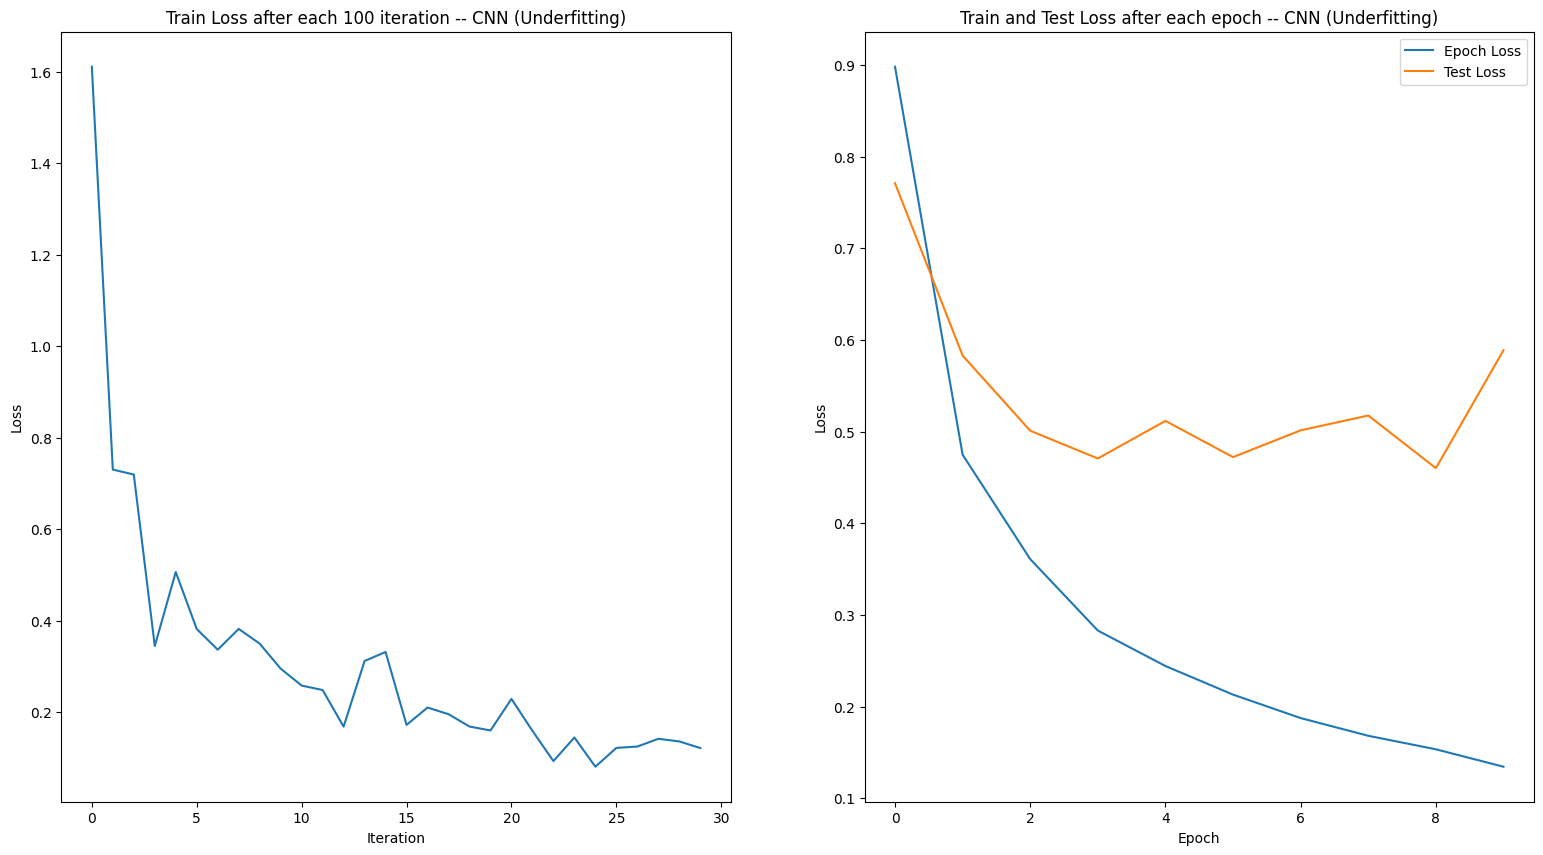

In [98]:
plt.figure(figsize=(19, 10))
plt.subplot(1, 2, 1)
plt.plot(under_train_loss, label='Train Loss')
plt.title('Train Loss after each 100 iteration -- CNN (Underfitting)')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(under_epoch_loss, label='Epoch Loss')
plt.plot(under_test_loss, label='Test Loss')
plt.title('Train and Test Loss after each epoch -- CNN (Underfitting)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [99]:
th.save(under_model.state_dict(), 'under_model.pth')
# del under_model

In [100]:
under_model = CategoryClassifier()
under_model.load_state_dict(th.load('under_model.pth'))
under_model.to(device)

under_y_true, under_y_pred = evaluate_model_predictions(under_model, test_under_loader)

/var/folders/tc/8g6g_hgn5zx4bzcxx9688mhw0000gn/T/ipykernel_4018/3046821283.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  under_model.load_state_dict(th.load('under_mod

0.8058
                     precision    recall  f1-score   support

             Kurtis       0.70      0.95      0.81       813
        Men Tshirts       0.76      0.91      0.83      1280
             Sarees       0.99      0.88      0.93      2316
Women Tops & Tunics       0.68      0.81      0.74      2338
      Women Tshirts       0.87      0.67      0.76      3253

           accuracy                           0.81     10000
          macro avg       0.80      0.84      0.81     10000
       weighted avg       0.82      0.81      0.81     10000



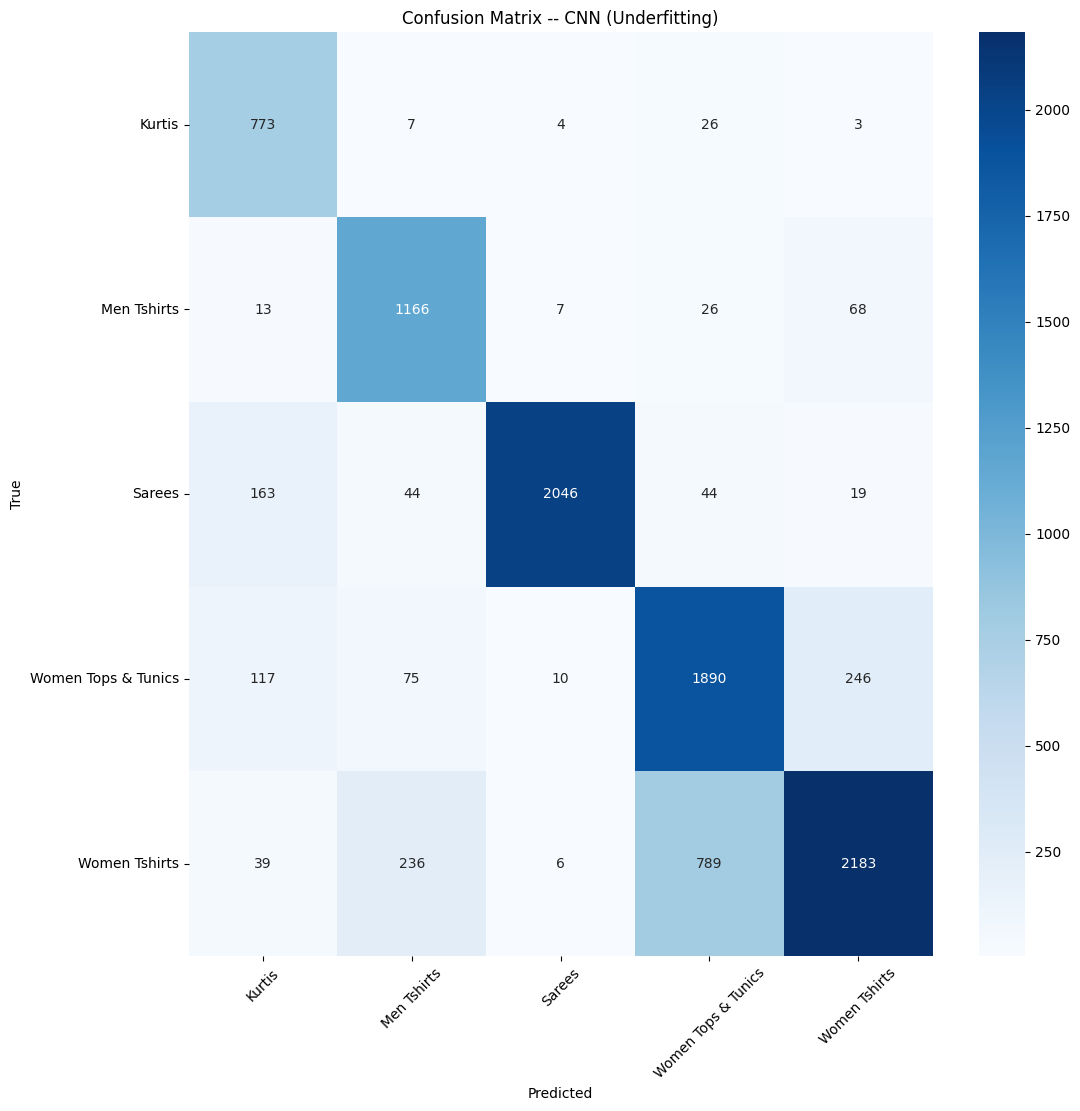

In [101]:
print(accuracy_score(under_y_true, under_y_pred))
print(classification_report(under_y_true, under_y_pred, target_names=lbe.classes_))

plt.figure(figsize=(12, 12))
cm = confusion_matrix(under_y_true, under_y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=lbe.classes_, yticklabels=lbe.classes_, cmap='Blues')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix -- CNN (Underfitting)')
plt.show()

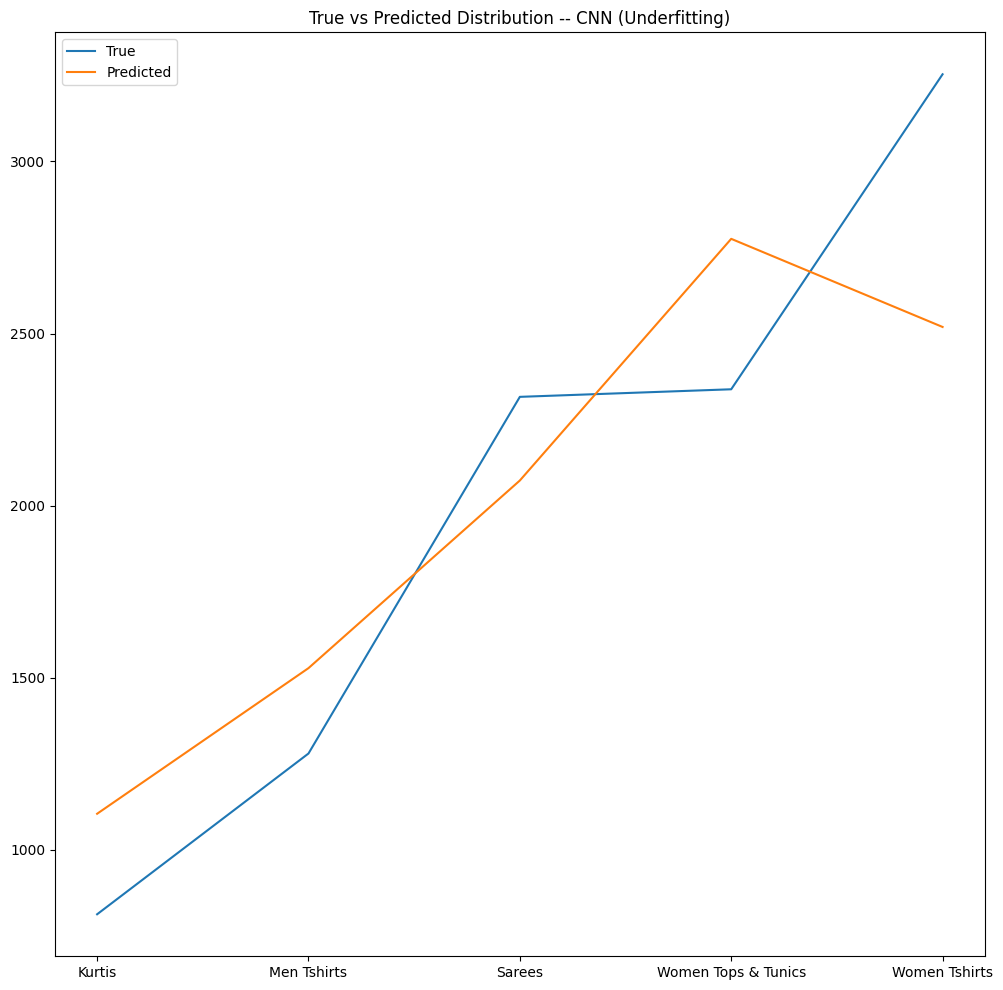

In [102]:
plt.figure(figsize=(12, 12))
plt.plot(lbe.classes_, cm.sum(axis=1), label='True')
plt.plot(lbe.classes_, cm.sum(axis=0), label='Predicted')
plt.legend()
plt.title('True vs Predicted Distribution -- CNN (Underfitting)')
plt.show()


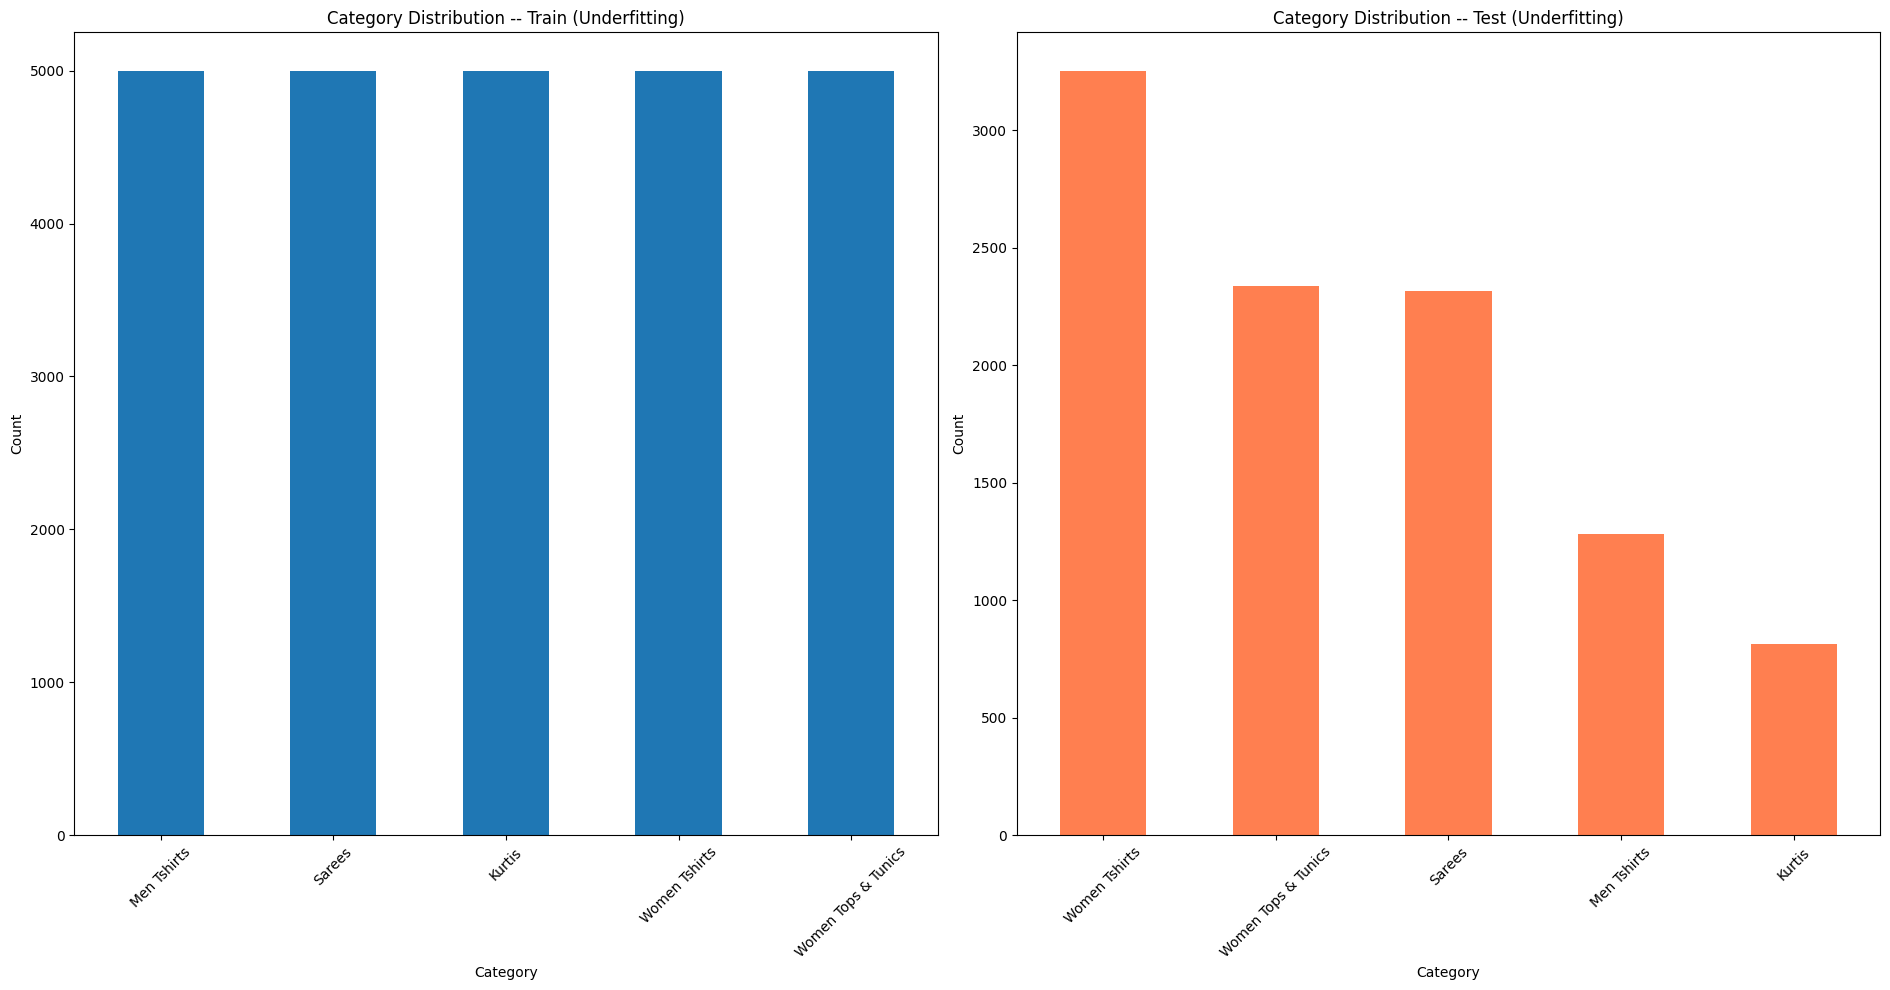

In [103]:
plt.figure(figsize=(19, 10))
plt.subplot(1, 2, 1)
train_under_pd['Category'].value_counts().plot(kind='bar')
plt.title('Category Distribution -- Train (Underfitting)')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
test_under_pd['Category'].value_counts().plot(kind='bar', color = 'coral')
plt.title('Category Distribution -- Test (Underfitting)')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

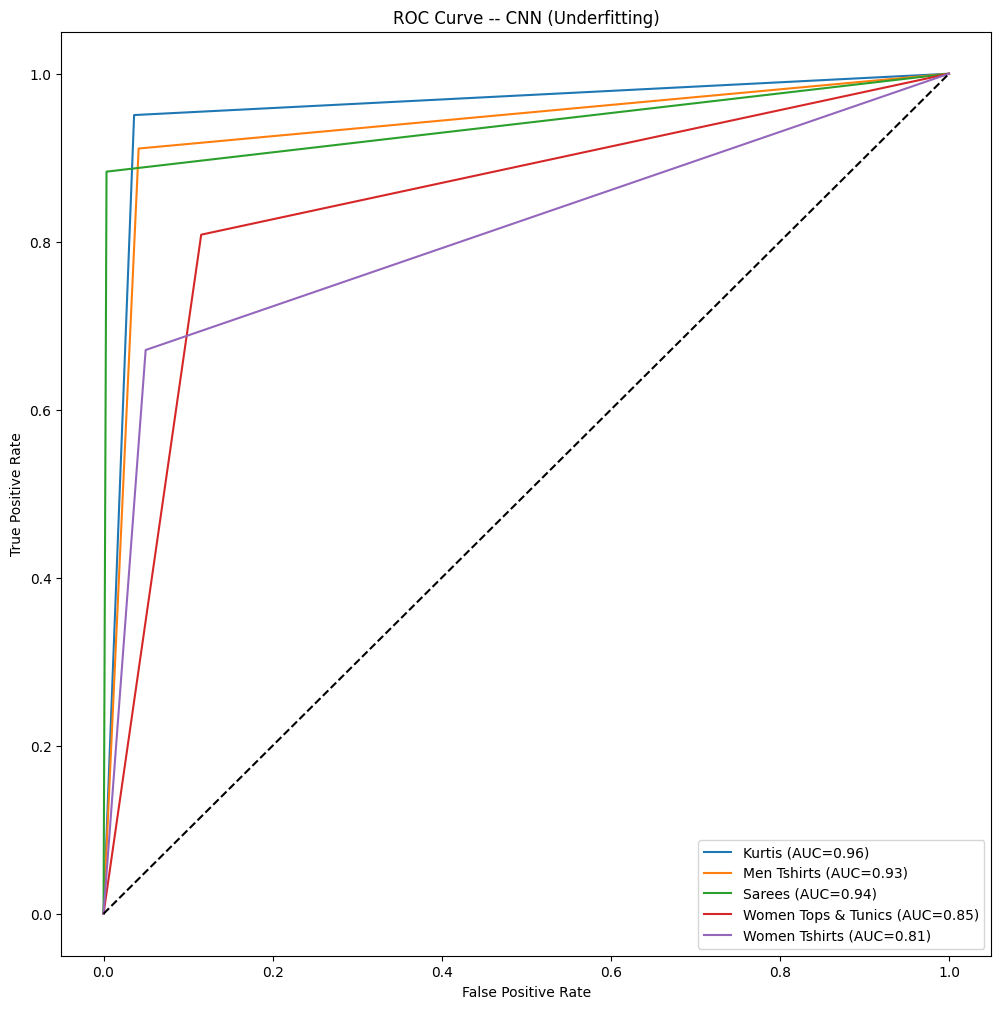

0.878625

In [104]:
# ROC Curve
under_y_true_onehot = np.eye(5)[under_y_true]
under_y_pred_onehot = np.eye(5)[under_y_pred]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(under_y_true_onehot[:, i], under_y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 12))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'{lbe.classes_[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- CNN (Underfitting)')
plt.legend()
plt.show()

# ROC AUC Score
roc_auc_score(under_y_true_onehot, under_y_pred_onehot, average='micro')